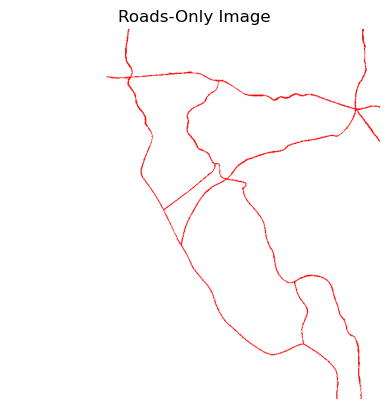

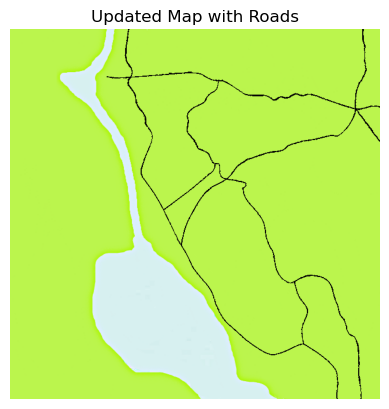

In [10]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the images
roads_image_path = "CF_Highlighted_roads.png"  # Ensure this is in the same directory
base_image_path = "map1.png"  # Ensure this is in the same directory

roads_image = Image.open(roads_image_path).convert("RGB")
base_image = Image.open(base_image_path).convert("RGB")

# Convert images to numpy arrays
roads_array = np.array(roads_image)
base_array = np.array(base_image)

# Step 1: Create a roads-only image (all non-red pixels become white)
roads_cleaned = np.ones_like(roads_array) * 255  # Start with a white image

# Iterate through all the pixels
for i in range(roads_array.shape[0]):
    for j in range(roads_array.shape[1]):
        r, g, b = roads_array[i, j]
        if (r > 100 and g < 100 and b < 100):  # If the pixel is red
            roads_cleaned[i, j] = [255, 0, 0]
        else:
            roads_cleaned[i, j] = [255, 255, 255]

# Convert back to image
roads_output_image = Image.fromarray(roads_cleaned)
roads_output_image.save("roads.png")

# Display the cleaned roads image
plt.imshow(roads_output_image)
plt.axis("off")
plt.title("Roads-Only Image")
plt.show()

# Step 2: Apply the roads mask onto the base map
roads_array = np.array(roads_output_image)  # Reload as array

# Iterate through all the pixels
for i in range(roads_array.shape[0]):
    for j in range(roads_array.shape[1]):
        r, g, b = roads_array[i, j]
        if not (r == 255 and g == 255 and b == 255):  # If the pixel is not white
            base_array[i, j] = [0, 0, 0]  # Set the corresponding pixel in base_array to black

# Convert back to image
final_output_image = Image.fromarray(base_array)
final_output_image.save("updated_map.png")

# Display the final updated map
plt.imshow(final_output_image)
plt.axis("off")
plt.title("Updated Map with Roads")
plt.show()


In [ ]:
import csv
from PIL import Image

# Load the image
image_path = "./Images/updated_map.png"
image = Image.open(image_path)
pixels = image.load()
width, height = image.size

# Output CSV file path
csv_path = "./Images/map_data.csv"

# Write pixel data to CSV
with open(csv_path, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["x", "y", "R", "G", "B"])  # Header row
    
    for y in range(height):
        for x in range(width):
            r, g, b = pixels[x, y][:3]  # Get RGB values
            writer.writerow([x, y, r, g, b])

print(f"CSV file saved at {csv_path}")


FileNotFoundError: [Errno 2] No such file or directory: './Images/map_data.csv'

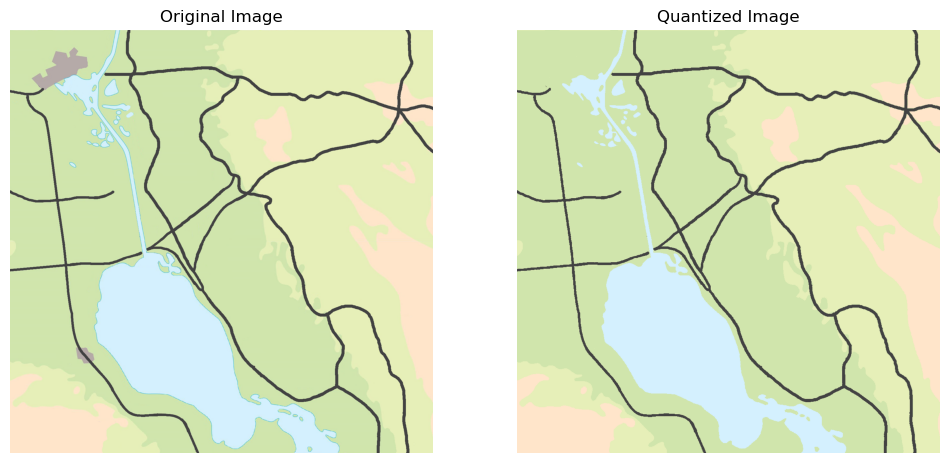

In [4]:
import numpy as np
import cv2
from scipy.spatial import KDTree
from PIL import Image
import matplotlib.pyplot as plt

# Define the color palette (RGB format)
palette = np.array([
    (212, 240, 254), #Terrain: water
    (208, 229, 172), #Terrain: canal-bank
    (230, 239, 184), #Terrain: sandy
    (255, 229, 202), #Terrain: desert
    # (181, 170, 168),
    (66, 66, 66) #Terrain: road
])

# Load the image
image_path = "./Images/final battlemap input 1024.png"
image = Image.open(image_path).convert("RGB")  # Ensure it's in RGB format
image_array = np.array(image)

# Flatten image array for processing
pixels = image_array.reshape(-1, 3)

# Use KDTree to efficiently find the closest color in the palette
kdtree = KDTree(palette)
_, indices = kdtree.query(pixels)

# Replace colors with closest palette colors
new_pixels = palette[indices]

# Reshape back to original image shape
new_image_array = new_pixels.reshape(image_array.shape)

# Convert back to image format and save
new_image = Image.fromarray(new_image_array.astype(np.uint8))
output_path = "./Images/finalbattlemap_quantized.png"
new_image.save(output_path)

# Display the original and quantized images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(new_image)
ax[1].set_title("Quantized Image")
ax[1].axis("off")

plt.show()


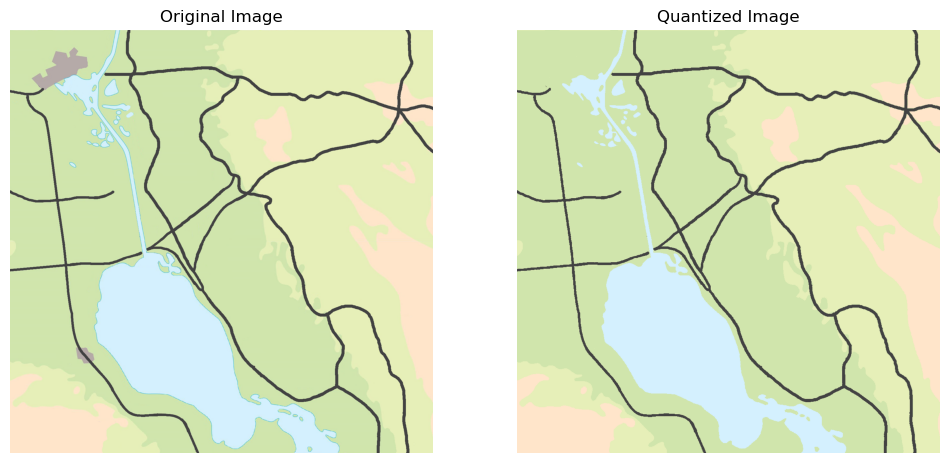

In [6]:
import numpy as np
import cv2
from scipy.spatial import KDTree
from PIL import Image
import matplotlib.pyplot as plt

# Define the color palette (RGB format)
palette = np.array([
    (212, 240, 254), #Terrain: water
    (208, 229, 172), #Terrain: canal-bank
    (230, 239, 184), #Terrain: sandy
    (255, 229, 202), #Terrain: desert
    (66, 66, 66)     #Terrain: road
])

terrain_names = [
    "water",
    "canal-bank",
    "sandy",
    "desert",
    "road"
]

# --- STEP 1: Quantize the original image using the palette ---

# Load the image
image_path = "./Images/final battlemap input 1024.png"
image = Image.open(image_path).convert("RGB")  # Ensure it's in RGB format
image_array = np.array(image)

# Flatten image array for processing
pixels = image_array.reshape(-1, 3)

# Use KDTree to efficiently find the closest color in the palette
kdtree = KDTree(palette)
_, indices = kdtree.query(pixels)

# Replace colors with closest palette colors
new_pixels = palette[indices]

# Reshape back to original image shape
new_image_array = new_pixels.reshape(image_array.shape)

# Convert back to image format and save
new_image = Image.fromarray(new_image_array.astype(np.uint8))
output_path = "./Images/finalbattlemap_quantized.png"
new_image.save(output_path)

# Display the original and quantized images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(new_image)
ax[1].set_title("Quantized Image")
ax[1].axis("off")

plt.show()

# --- STEP 2: Generate mask images, one per palette color ---

# Load the quantized image that you just saved
quantized_image = Image.open(output_path).convert("RGB")
quantized_array = np.array(quantized_image)

# For each color in the palette, create and save a mask
for color, terrain in zip(palette, terrain_names):
    # Create a boolean mask where pixels match the specific color
    # np.all will check equality across the RGB channels
    matches_color = np.all(quantized_array == color, axis=-1)

    # Initialize an empty (black) mask the same height/width as the image
    mask_array = np.zeros((quantized_array.shape[0], quantized_array.shape[1]), dtype=np.uint8)

    # Set the matching pixels to white (255)
    mask_array[matches_color] = 255

    # Convert to a Pillow Image and save
    mask_image = Image.fromarray(mask_array, mode='L')
    mask_image.save(f"./Images/terrain_masks/{terrain}_mask.png")
